# Get the clinician diagonosis

In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.utils import resample

In [31]:
with open("../preprocess_data/processed_data/processed_csv/first_visit_features/train_first_visit_features.csv", "rt") as fin:
    train_features = pd.read_csv(fin, low_memory=False)
with open("../preprocess_data/processed_data/processed_csv/first_visit_features/valid_first_visit_features.csv", "rt") as fin:
    valid_features = pd.read_csv(fin, low_memory=False)
with open("../preprocess_data/processed_data/processed_csv/first_visit_features/test_first_visit_features.csv", "rt") as fin:
    test_features = pd.read_csv(fin, low_memory=False)

In [32]:
# get the clinical diagonsis
def label_clinical_diagonsis(row):
    if (row["NACCALZD"] == 1) and (row["NACCLBDE"] != 1):
        return 0
    elif (row["NACCALZD"] != 1) and (row["NACCLBDE"] == 1):
        return 1
    elif (row["NACCALZD"] == 1) and (row["NACCLBDE"] == 1):
        return 2
    else:
        return 3

In [33]:
# to add a column and fill clinical diagnosis for each row in test set
test_features["clinician_diagnosis"] = test_features.apply(lambda row: label_clinical_diagonsis(row), axis=1)

In [34]:
len(test_features), len(pd.unique(test_features["NACCID"]))

(380, 380)

In [35]:
# to get the true label statistics for test features
test_features.groupby("label").count()["NACCID"]

label
0    152
1     10
2    115
3    103
Name: NACCID, dtype: int64

# Compute the clinician confidence interval

In [36]:
# step 1: we get a list containing (naccid, label, clinician_diagnosis)
test_label_diag = test_features[["NACCID", "label", "clinician_diagnosis"]].values

In [37]:
test_label_diag

array([['NACC014159', 0, 0],
       ['NACC017967', 0, 0],
       ['NACC020729', 3, 2],
       ...,
       ['NACC988182', 1, 1],
       ['NACC993747', 0, 0],
       ['NACC997719', 3, 3]], dtype=object)

In [38]:
test_index = np.array([3,6,12,14])
test_label_diag[test_index]

array([['NACC021496', 3, 3],
       ['NACC030229', 3, 3],
       ['NACC061943', 2, 3],
       ['NACC068046', 3, 0]], dtype=object)

In [52]:
# step 2: define a function to get the bootstrap sample sets
def construct_bootstrap_test_samples(feature_list, sample_size):
    """
    Args:
        - feature_list: the list containing all test features
        - sample_size: the number of samples in each bootstrap sample
    """
    index_array = np.arange(len(feature_list))  # get the index array for test_features
    resampled_index_array = resample(index_array, n_samples=sample_size)
    #resampled_index_list = resampled_index_array.tolist()
    features_resampled = [feature_list[i] for i in resampled_index_array]

    return features_resampled, resampled_index_array


In [53]:
len(test_label_diag)

380

In [54]:
construct_bootstrap_test_samples(test_label_diag, 4)

([array(['NACC316187', 2, 0], dtype=object),
  array(['NACC139670', 2, 0], dtype=object),
  array(['NACC219715', 3, 3], dtype=object),
  array(['NACC239438', 3, 0], dtype=object)],
 array([148,  50,  85,  98]))

In [61]:
# step 3: use sklearn to compute the F1 score for each metrics
def compute_f1_scores(sampled_array):
    """
    Compute F1 scores for macro, micro, and each disease
    Args:
        - sampled_array: numpy array containing resampled test sample.
                         each sample has the format array([naccid, label, clinician_diagnosis])
    """
    resampled_labels = [sample[1] for sample in sampled_array]
    resampled_clinician_diag = [sample[2] for sample in sampled_array]
    
    eval_stat = {"f1_macro_scores": f1_score(resampled_labels, resampled_clinician_diag, average="macro"),
                 "f1_micro_scores": f1_score(resampled_labels, resampled_clinician_diag, average="micro"),
                 "f1s_scores": f1_score(resampled_labels, resampled_clinician_diag, average=None)}
    
    return eval_stat

In [62]:
# step 3: use bootstrap to get the f1 scores for each bootstap sample set

# configure bootstrap
n_iterations = 1000
n_size = int(len(test_label_diag)*0.8)

# run bootstrap
stats_list = []  # python list containing eval_stats for different bootstrap samples
sample_indices_list = []  # randomly bootstrap sample indices 

for iteration in range(n_iterations):

    # prepare bootstrap test set
    test_set, sample_indices = construct_bootstrap_test_samples(test_label_diag, n_size)
    sample_indices_list.append(sample_indices)

    # compute the F1 scores
    f1_scores = compute_f1_scores(test_set)
    stats_list.append(f1_scores)

In [64]:
len(stats_list)

1000

# Get the bootstrap statistics for each metrics

In [68]:
import matplotlib.pyplot as plt
from statistics import mean

In [89]:
# define a function to get the confident interval for the metrics\n",
def get_confident_interval(metrics_list, alpha):
    """
    Args:
        - metrics_list: list containing all the bootstrap value for this metrics\n",
        - alpha: the chosen percentile
    """
    
    p = ((1.0 - alpha) / 2.0) * 100,
    lower = np.percentile(metrics_list, p),
    p = (alpha + ((1.0-alpha)/2.0)) * 100,
    upper = np.percentile(metrics_list, p),
    print("{}% confidence interval {} and {}".format(alpha*100, lower[0], upper[0]))


In [90]:
alpha = 0.95

mean is 0.3713774041404357
95.0% confidence interval [0.30338562] and [0.44428589]


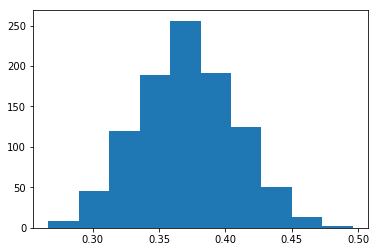

In [91]:
### for macro f1 score ###
macro_f1_scores = [sample_stats["f1_macro_scores"] for sample_stats in stats_list]
print("mean is", mean(macro_f1_scores))
get_confident_interval(macro_f1_scores, alpha)
plt.hist(macro_f1_scores)
plt.show()

mean is 0.4739605263157895
95.0% confidence interval [0.41776316] and [0.52960526]


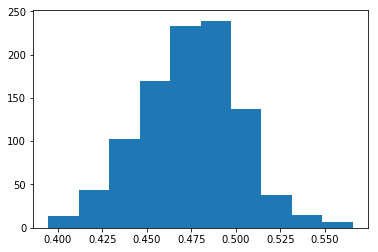

In [92]:
### for micro f1 score ###
micro_f1_scores = [sample_stats["f1_micro_scores"] for sample_stats in stats_list]
print("mean is", mean(micro_f1_scores))
get_confident_interval(micro_f1_scores, alpha)
plt.hist(micro_f1_scores)
plt.show()

mean is 0.5562310159172928
95.0% confidence interval [0.48854962] and [0.62416107]


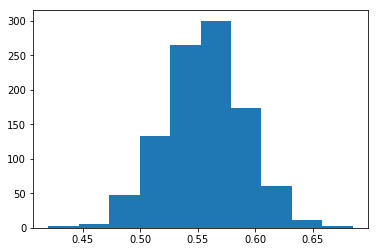

In [98]:
### for PURE AD f1 score ###
pure_ad_f1_scores = [sample_stats["f1s_scores"][0] for sample_stats in stats_list]
print("mean is", mean(pure_ad_f1_scores))
get_confident_interval(pure_ad_f1_scores, alpha)
plt.hist(pure_ad_f1_scores)
plt.show()

mean is 0.28321855491387854
95.0% confidence interval [0.] and [0.52649123]


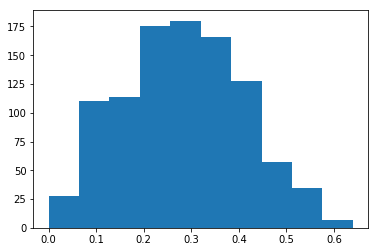

In [99]:
### for PURE LBD f1 score ###
pure_lbd_f1_scores = [sample_stats["f1s_scores"][1] for sample_stats in stats_list]
print("mean is", mean(pure_lbd_f1_scores))
get_confident_interval(pure_lbd_f1_scores, alpha)
plt.hist(pure_lbd_f1_scores)
plt.show()

mean is 0.062409494272759915
95.0% confidence interval [0.] and [0.13333333]


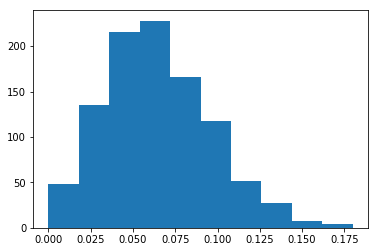

In [100]:
### for MIXED f1 score ###
mixed_f1_scores = [sample_stats["f1s_scores"][2] for sample_stats in stats_list]
print("mean is", mean(mixed_f1_scores))
get_confident_interval(mixed_f1_scores, alpha)
plt.hist(mixed_f1_scores)
plt.show()

mean is 0.5836505514578114
95.0% confidence interval [0.4917987] and [0.66666667]


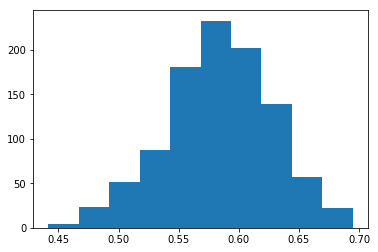

In [101]:
### for OTHERS f1 score ###
others_f1_scores = [sample_stats["f1s_scores"][3] for sample_stats in stats_list]
print("mean is", mean(others_f1_scores))
get_confident_interval(others_f1_scores, alpha)
plt.hist(others_f1_scores)
plt.show()